In [549]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, accuracy_score

import shap

# Data analysis

In [520]:
seed = 42

torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
cuda = torch.cuda.is_available()
if cuda is True:
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [521]:
path = "Placement_Data_Full_Class.csv"

In [522]:
df = pd.read_csv(path)

In [523]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [524]:
print("duplicates: ", df.duplicated(keep=False).sum())
print("imbalance count: \n", df['status'].value_counts())
print("\nimbalance ratio:\n", df['status'].value_counts(normalize=True))

duplicates:  0
imbalance count: 
 status
Placed        148
Not Placed     67
Name: count, dtype: int64

imbalance ratio:
 status
Placed        0.688372
Not Placed    0.311628
Name: proportion, dtype: float64


# Preprocessing

In [525]:
df.drop(["sl_no", "salary"], axis=1, inplace=True)

In [526]:
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})

In [527]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=df["status"], shuffle=True)

In [528]:
#gender	ssc_p	ssc_b	hsc_p	hsc_b	hsc_s	degree_p	degree_t	workex	etest_p	specialisation	mba_p	status
cat_cols = ["gender", "ssc_b", "hsc_b", "hsc_s", "degree_t", "workex", "specialisation",]
num_cols = ["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]

In [529]:

ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(x_train[cat_cols])

x_train_enc1 = pd.DataFrame(data=ohe.transform(x_train[cat_cols]).toarray(), 
							columns=ohe.get_feature_names_out())

x_train_enc = x_train.copy()

x_train_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_train_enc = pd.concat([x_train_enc.reset_index(drop=True), x_train_enc1], axis=1)

#Apply on test data
x_test_enc1 = pd.DataFrame(data=ohe.transform(x_test[cat_cols]).toarray(),
							columns=ohe.get_feature_names_out())

x_test_enc = x_test.copy()

x_test_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_test_enc = pd.concat([x_test_enc.reset_index(drop=True), x_test_enc1], axis=1)


In [530]:
scaler = StandardScaler()
scaler.fit(x_train_enc[num_cols])
x_train_enc[num_cols] = scaler.transform(x_train_enc[num_cols])
x_test_enc[num_cols] = scaler.transform(x_test_enc[num_cols])

In [531]:
pipe = Pipeline([
	("rf", RandomForestClassifier(class_weight="balanced", random_state=seed, max_depth=5))
])


In [532]:
pipe.fit(x_train_enc, y_train)

/Users/sarahsodini/Documents/Universitet/KTH/Åk4/Polito/EaTAI/XAI-Project/ranking_env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])

In [550]:
y_pred = pipe.predict(x_test_enc)

In [ ]:
print(f"Train accuracy: {pipe.score(x_train_enc, y_train)}")
print(f"Test accuracy: {pipe.score(x_test_enc, y_test)}")

report = classification_report(y_true=y_test, y_pred=y_pred)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(report)

Train accuracy: 0.9825581395348837
Test accuracy: 0.9069767441860465
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.93      0.93      0.93        30

    accuracy                           0.91        43
   macro avg       0.89      0.89      0.89        43
weighted avg       0.91      0.91      0.91        43

Accuracy:  0.9069767441860465


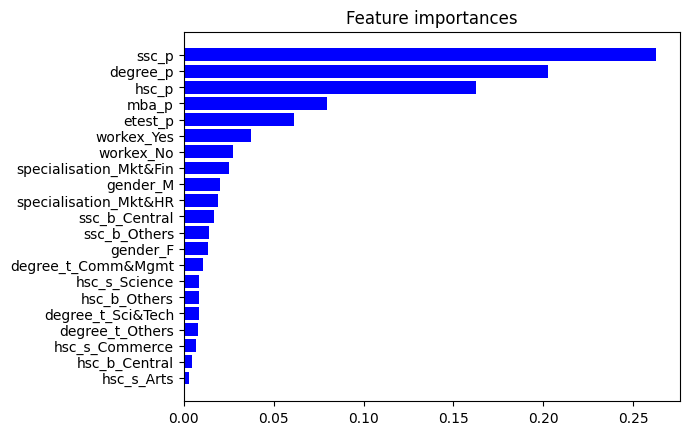

In [534]:
feature_importance = pipe["rf"].feature_importances_
feature_names = x_train_enc.columns

sorted_idx = feature_importance.argsort()

#Plot the feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], color='blue')
plt.title("Feature importances")
# plt.savefig("pictures/feat_imp1_depth_5.png")  # high quality
plt.show()


In [545]:
perm_imp_test = permutation_importance(pipe, x_test_enc, y_test, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_test_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")

- ssc_p => Mean: 0.1465 ; Std: 0.0466
- hsc_p => Mean: 0.0651 ; Std: 0.0309
- degree_p => Mean: 0.0791 ; Std: 0.0467
- etest_p => Mean: 0.0256 ; Std: 0.0125
- mba_p => Mean: 0.0163 ; Std: 0.0149
- gender_F => Mean: 0.0186 ; Std: 0.0140
- gender_M => Mean: 0.0279 ; Std: 0.0093
- ssc_b_Central => Mean: -0.0047 ; Std: 0.0203
- ssc_b_Others => Mean: -0.0186 ; Std: 0.0271
- hsc_b_Central => Mean: 0.0070 ; Std: 0.0149
- hsc_b_Others => Mean: 0.0116 ; Std: 0.0116
- hsc_s_Arts => Mean: 0.0000 ; Std: 0.0000
- hsc_s_Commerce => Mean: 0.0186 ; Std: 0.0093
- hsc_s_Science => Mean: 0.0233 ; Std: 0.0180
- degree_t_Comm&Mgmt => Mean: 0.0279 ; Std: 0.0228
- degree_t_Others => Mean: 0.0000 ; Std: 0.0000
- degree_t_Sci&Tech => Mean: 0.0372 ; Std: 0.0186
- workex_No => Mean: -0.0023 ; Std: 0.0125
- workex_Yes => Mean: -0.0023 ; Std: 0.0125
- specialisation_Mkt&Fin => Mean: 0.0302 ; Std: 0.0182
- specialisation_Mkt&HR => Mean: 0.0140 ; Std: 0.0186


In [546]:
perm_imp_train = permutation_importance(pipe, x_train_enc, y_train, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_train_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")

- ssc_p => Mean: 0.1465 ; Std: 0.0466
- hsc_p => Mean: 0.0651 ; Std: 0.0309
- degree_p => Mean: 0.0791 ; Std: 0.0467
- etest_p => Mean: 0.0256 ; Std: 0.0125
- mba_p => Mean: 0.0163 ; Std: 0.0149
- gender_F => Mean: 0.0186 ; Std: 0.0140
- gender_M => Mean: 0.0279 ; Std: 0.0093
- ssc_b_Central => Mean: -0.0047 ; Std: 0.0203
- ssc_b_Others => Mean: -0.0186 ; Std: 0.0271
- hsc_b_Central => Mean: 0.0070 ; Std: 0.0149
- hsc_b_Others => Mean: 0.0116 ; Std: 0.0116
- hsc_s_Arts => Mean: 0.0000 ; Std: 0.0000
- hsc_s_Commerce => Mean: 0.0186 ; Std: 0.0093
- hsc_s_Science => Mean: 0.0233 ; Std: 0.0180
- degree_t_Comm&Mgmt => Mean: 0.0279 ; Std: 0.0228
- degree_t_Others => Mean: 0.0000 ; Std: 0.0000
- degree_t_Sci&Tech => Mean: 0.0372 ; Std: 0.0186
- workex_No => Mean: -0.0023 ; Std: 0.0125
- workex_Yes => Mean: -0.0023 ; Std: 0.0125
- specialisation_Mkt&Fin => Mean: 0.0302 ; Std: 0.0182
- specialisation_Mkt&HR => Mean: 0.0140 ; Std: 0.0186


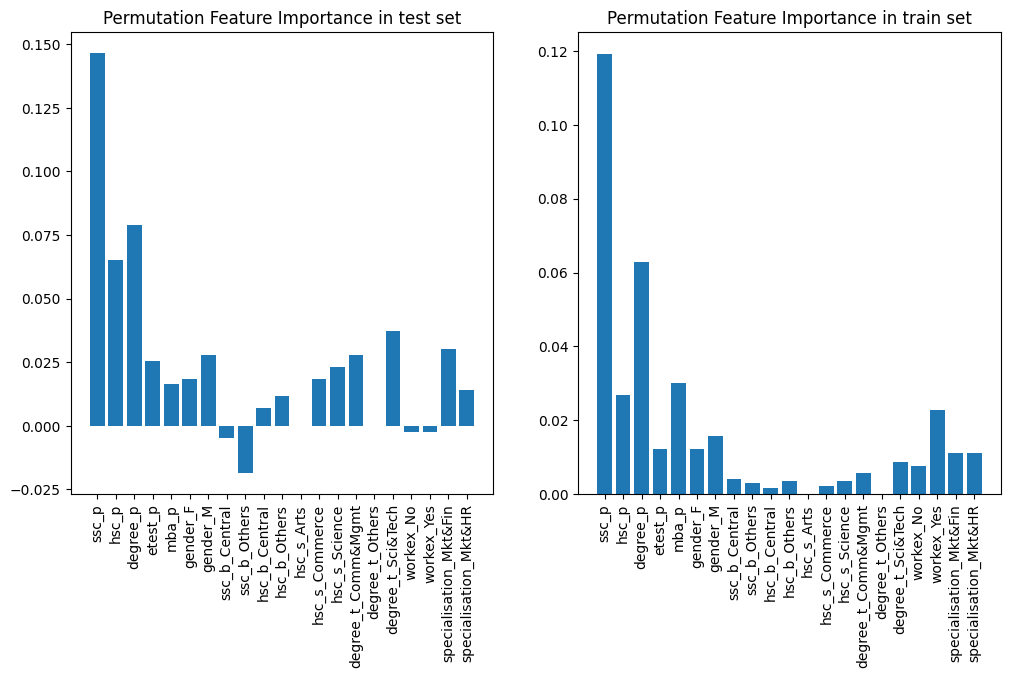

In [547]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(x_test_enc.shape[1]), perm_imp_test.importances_mean)
plt.xticks(range(x_test_enc.shape[1]), x_test_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in test set")

plt.subplot(1, 2, 2)
plt.bar(range(x_train_enc.shape[1]), perm_imp_train.importances_mean)
plt.xticks(range(x_train_enc.shape[1]), x_train_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in train set")

# plt.savefig("/pictures/pre_feat_imp2_depth_5.png", dpi=300, bbox_inches='tight')  # high quality

plt.show()

# Ranking

In [538]:
probs = pipe.predict_proba(x_test_enc)[:, 1]

In [539]:
ranking = probs.argsort()[::-1]
print(ranking)

[ 1 23 24 15  9 34 26 13 31  2  4 36  6  7 22 35 29 17 18 40 28 27 11 14
 10 12 25  0  5 30 38 32 16  3 41 37 21 42  8 20 39 19 33]


In [541]:
x_test.iloc[1]

gender                    M
ssc_p                  74.0
ssc_b               Central
hsc_p                  70.0
hsc_b               Central
hsc_s               Science
degree_p               72.0
degree_t          Comm&Mgmt
workex                  Yes
etest_p                60.0
specialisation      Mkt&Fin
mba_p                 57.24
Name: 60, dtype: object

In [ ]:
# Rank x and y accordingly
x_test_ranked = x_test.iloc[ranking].reset_index(drop=True)
y_test_ranked = y_test.iloc[ranking].reset_index(drop=True)
probs_ranked = probs[ranking]

In [552]:
# Select top 5
k = 5

x_topk = x_test_ranked.iloc[:k]
y_topk = y_test_ranked.iloc[:k]
probs_topk = probs_ranked[:k]

In [553]:
topk_df = x_topk.copy()
topk_df['true_label'] = y_topk
topk_df['pred_prob'] = probs_topk

print(topk_df)

  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p   degree_t  \
0      M   74.0  Central   70.0  Central   Science      72.0  Comm&Mgmt   
1      M   69.6  Central   68.4  Central  Commerce      78.3  Comm&Mgmt   
2      M   80.0   Others   73.0   Others  Commerce      75.0  Comm&Mgmt   
3      M   77.0   Others   75.0   Others   Science      73.0   Sci&Tech   
4      M   83.0   Others   74.0   Others   Science      66.0  Comm&Mgmt   

  workex  etest_p specialisation  mba_p  true_label  pred_prob  
0    Yes    60.00        Mkt&Fin  57.24           1   0.972491  
1    Yes    60.00        Mkt&Fin  63.70           1   0.958411  
2     No    61.00        Mkt&Fin  58.78           1   0.941284  
3     No    80.00        Mkt&Fin  67.05           1   0.939498  
4     No    68.92         Mkt&HR  58.46           1   0.935366  


# SHAP

In [558]:
id_instance_1 = 1
id_instance_2 = 24
class_instance = 1

sample = x_test_enc
masker = shap.maskers.Independent(data=x_test_enc)

explainer = shap.Explainer(model=pipe["rf"].predict_proba, # the function predict_proba
                           masker=masker)

shap_values = explainer.shap_values(sample)

shap_values_instance_1 = shap_values[id_instance_1][:, class_instance]
shap_values_instance_2 = shap_values[id_instance_2][:, class_instance]
print(shap_values_instance_1)
print()
print(shap_values_instance_2)

[ 0.09555245  0.0285611   0.06464551 -0.00332869  0.01830272  0.01049565
  0.01440097 -0.00518813 -0.00060532 -0.00035258 -0.00165076  0.00069007
  0.00063663  0.00020636  0.00654737  0.00272022  0.0043342   0.04253789
  0.04725988  0.01266228  0.01260866]

[ 0.12481565  0.05245     0.07997403 -0.00546135  0.00681072  0.01113892
  0.01248343  0.0114594   0.0103913  -0.00118523  0.00063526  0.00114082
  0.00014098 -0.00156514  0.01144617  0.002579    0.00542283 -0.00429892
 -0.00712383  0.00460993  0.0039649 ]


In [566]:
shap_diff = np.subtract(shap_values_instance_1, shap_values_instance_2)
val_diff = np.subtract(x_test_enc.iloc[1], x_test_enc.iloc[24])

prod = shap_diff * val_diff

sum = np.sum(prod)
print(sum)

0.032169514770056036
